In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

In [2]:
sjogren_path = '../Data/new_sjogren_file/'
healthy_path = '../Data/in_house_healthy/'

In [26]:
def concat_usage(path):
    data = defaultdict(pd.DataFrame)
    for file in os.listdir(path):
        df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
        v, _, _ = df.get_mature_usage()
        v1, _, _ = df.get_naive_usage()
        mature_data = v.div(v.sum())
        naive_data = v1.div(v1.sum())
        # Combine the data into a single DataFrame
        df = pd.DataFrame({'Naive Repertoire': naive_data, 'Mature Repertoire': mature_data})
        data[file.split('_')[0]] = df
    dataframes = []
    for patient, repertoires in data.items():
        dataframes.append(repertoires)
    combined_df = pd.concat(dataframes)
    return combined_df

concat_patients = concat_usage(sjogren_path)
concat_healthy = concat_usage(healthy_path)
# # Plot the data as a bar graph
# ax = df.plot(kind='bar', figsize=(12, 6), rot=45, width=0.8)
#
# # Customize the plot
# plt.title("IGHV Gene Usage in Naive and Mature Repertoires")
# plt.xlabel("IGHV Gene Types")
# plt.ylabel("Normalized Counts")
# plt.legend(title='Repertoire')
#
# # Show the plot
# plt.tight_layout()
# plt.show()

In [68]:
data_patients = list(concat_patients.groupby('v_call'))
data_healthy = list(concat_healthy.groupby('v_call'))
data_patients_naive = defaultdict(list)
for i, ind in enumerate(data_patients):
    for row in ind[1].itertuples():
        data_patients_naive[ind[0]].append(row[2])

data_healthy_naive = defaultdict(list)
for i, ind in enumerate(data_healthy):
    for row in ind[1].itertuples():
        data_healthy_naive[ind[0]].append(row[2])


/Users/daeheonkwon/anaconda3/envs/IP/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/daeheonkwon/anaconda3/envs/IP/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


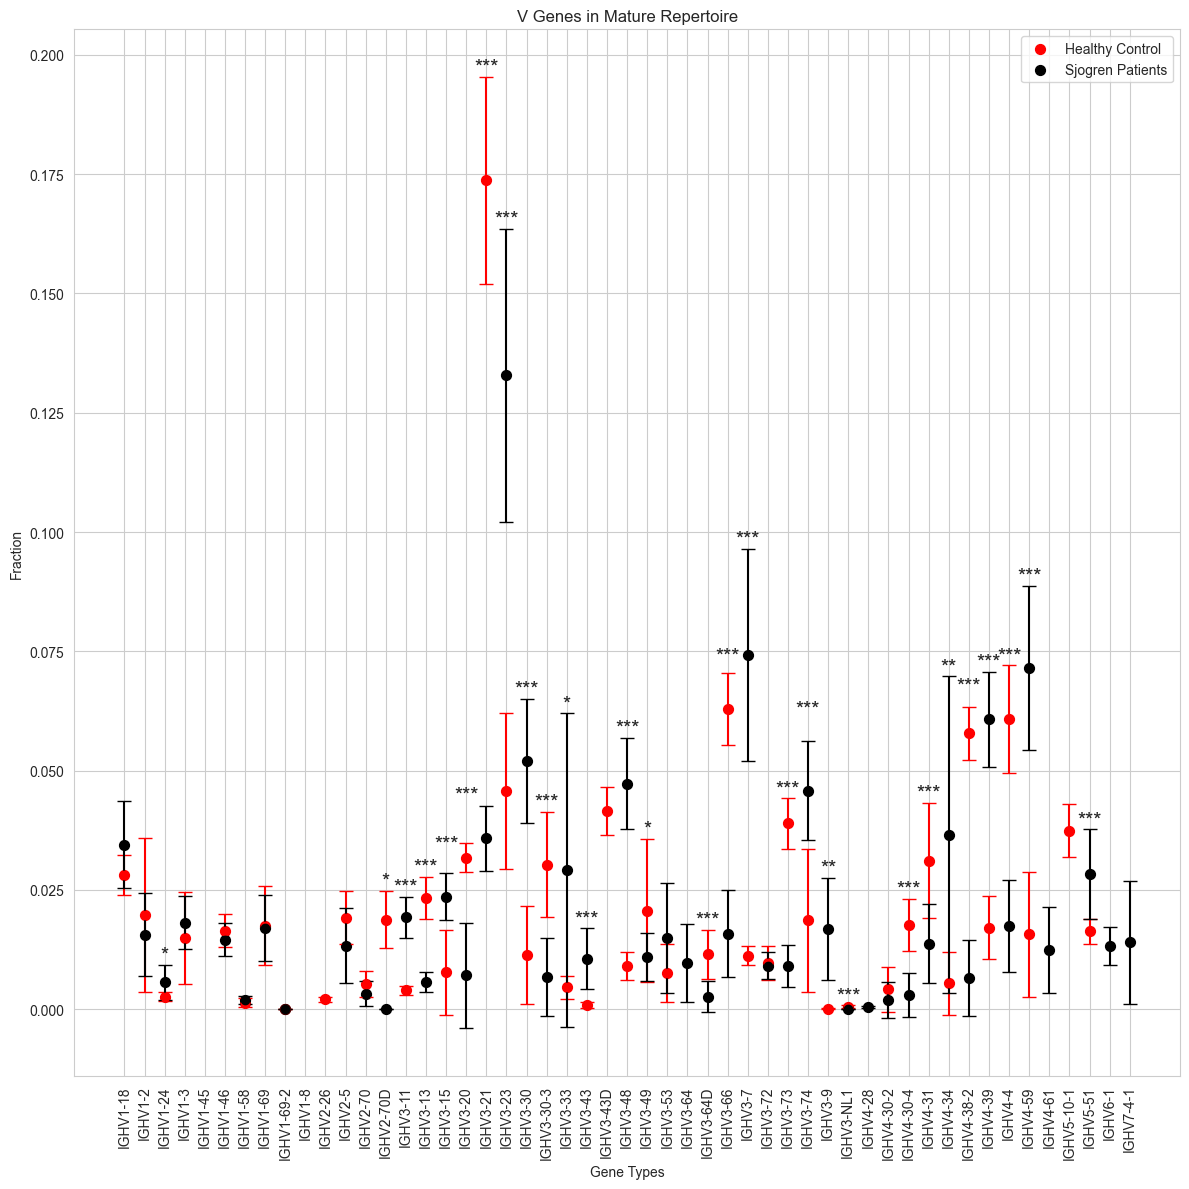

In [69]:
control_gene_types = list(data_healthy_naive.keys())
control_data_values = list(data_healthy_naive.values())

control_means = [np.mean(values) for values in control_data_values]
control_std = [np.std(values) for values in control_data_values]

exp_gene_types = list(data_patients_naive.keys())
exp_data_values = list(data_patients_naive.values())

exp_means = [np.mean(values) for values in exp_data_values]
exp_std = [np.std(values) for values in exp_data_values]

# Calculate p-values for each V gene using t-test
p_values = [stats.ttest_ind(control_data_values[i], exp_data_values[i]).pvalue for i in range(len(control_gene_types))]

# Create a dictionary to map p-values to significance levels
significance_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Initialize lists to store significance labels for each V gene
significance_labels = []

# Determine significance labels for each V gene
for p_value in p_values:
    for significance_level, label in significance_levels.items():
        if p_value <= significance_level:
            significance_labels.append(label)
            break
    else:
        significance_labels.append('')

plt.figure(figsize=(12, 12))
ax = plt.gca()

# Scatter plot and error bars for control and experimental groups
plt.scatter(range(len(control_gene_types)), control_means, label="Healthy Control", marker='o', color='red', s=50)
for i, mean_value in enumerate(control_means):
    plt.errorbar(i, mean_value, yerr=control_std[i], color='red', fmt='o', capsize=5)

plt.scatter(range(len(exp_gene_types)), exp_means, label="Sjogren Patients", marker='o', color='black', s=50)
for i, mean_value in enumerate(exp_means):
    plt.errorbar(i, mean_value, yerr=exp_std[i], color='black', fmt='o', capsize=5)

# Add significance labels over the bars
for i, label in enumerate(significance_labels):
    if label:
        plt.text(i, max(control_means[i], exp_means[i])+max(control_std[i], exp_std[i]), label, ha='center', va='bottom', fontsize=15)

plt.title("V Genes in Mature Repertoire")
plt.xlabel("Gene Types")
plt.ylabel("Fraction")
plt.xticks(range(len(exp_gene_types)), exp_gene_types, rotation=90)
plt.legend()

plt.tight_layout()
plt.savefig('../Data/Figures/v_genes_mature_repertoire.png', dpi=500)
plt.show()


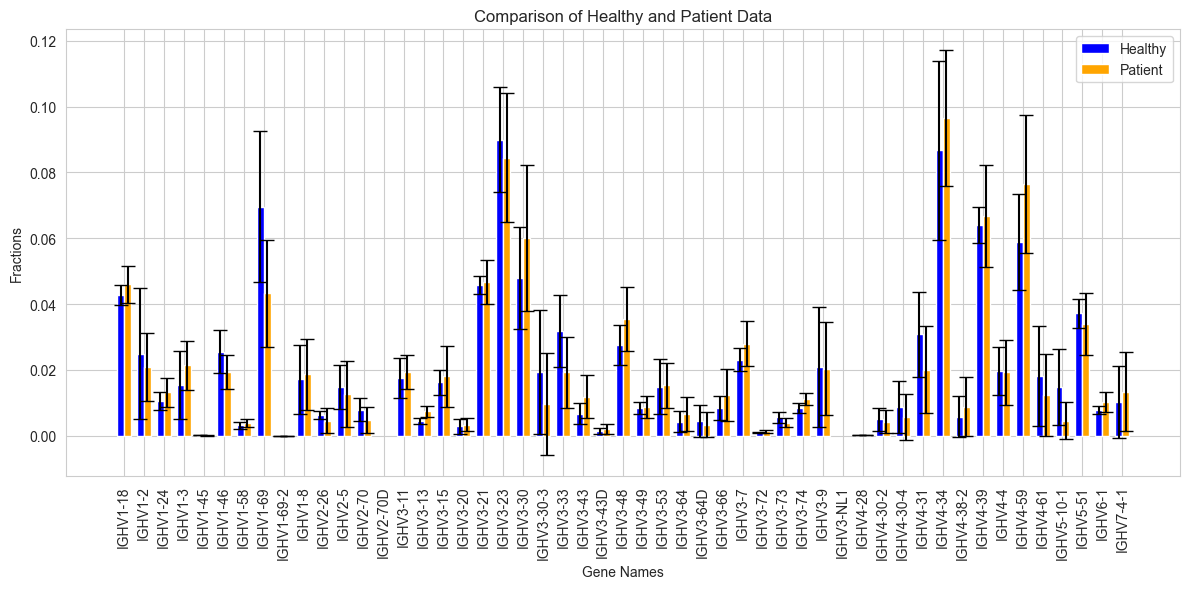

In [56]:
# Set the width of the bars
bar_width = 0.35

# Create an array representing the x-axis positions for the bars
x = range(len(data))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot healthy data
bar1 = ax.bar(x, data['Healthy_Value'], bar_width, label='Healthy', yerr=data['Healthy_Error'], capsize=5, color='blue')

# Plot patient data
bar2 = ax.bar([i + bar_width for i in x], data['Patient_Value'], bar_width, label='Patient', yerr=data['Patient_Error'], capsize=5, color='orange')

# Set x-axis labels to gene names
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(data.index, rotation=90)

# Set axis labels and title
ax.set_xlabel('Gene Names')
ax.set_ylabel('Fractions')
ax.set_title('Comparison of Healthy and Patient Data')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

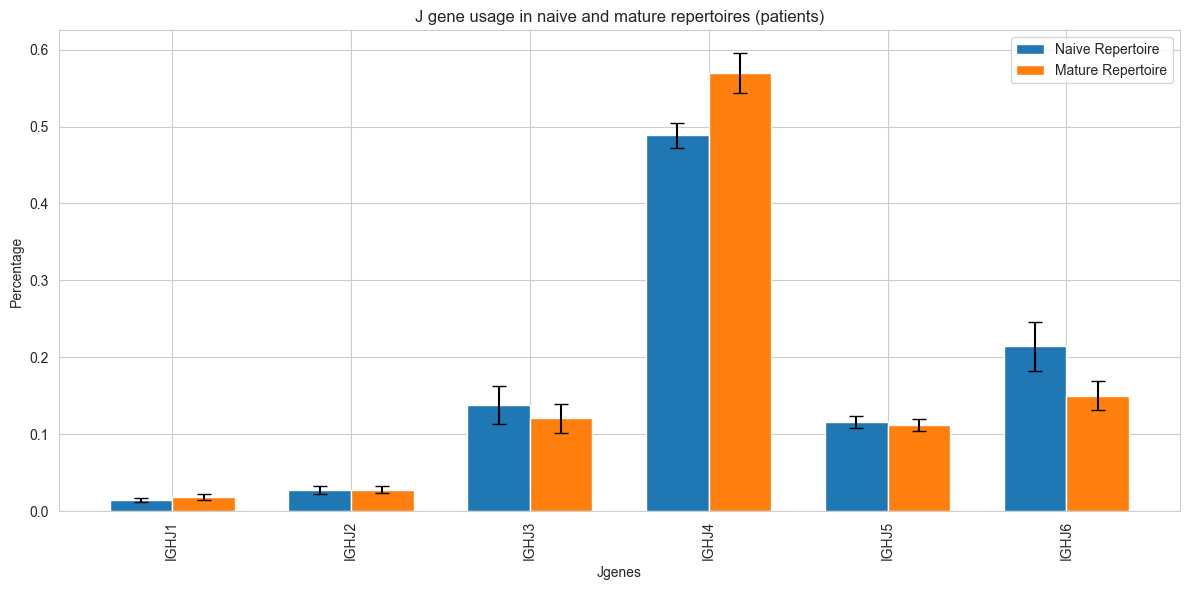

In [160]:

# Extract data
v_calls = data.index
naive_mean = data[('Naive Repertoire', 'mean')]
naive_std = data[('Naive Repertoire', 'std')]
mature_mean = data[('Mature Repertoire', 'mean')]
mature_std = data[('Mature Repertoire', 'std')]

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35

x = np.arange(len(v_calls))

naive_bars = ax.bar(x - bar_width / 2, naive_mean, bar_width, yerr=naive_std, label='Naive Repertoire', capsize=5)
mature_bars = ax.bar(x + bar_width / 2, mature_mean, bar_width, yerr=mature_std, label='Mature Repertoire', capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(v_calls, rotation=90)

ax.set_xlabel('Jgenes')
ax.set_ylabel('Percentage')
ax.set_title('J gene usage in naive and mature repertoires (patients)')

ax.legend()

plt.tight_layout()
plt.show()


In [111]:
df_list = []

for file in os.listdir(sjogren_path):
    df = preprocessing(pd.read_csv(os.path.join(sjogren_path,file), sep='\t'))
    df_list.append(df()[df()['v_call'] == 'IGHV1-69'])

concat_df = pd.concat(df_list, axis=0)
concat_df

,sequence_id,duplicate_count,frequency,sequence,sequence_aa,sequence_alignment,germline_alignment,v_call,d_call,j_call,...,cdr1_aa,cdr2_aa,cdr3_aa,rev_comp,productive,v_cigar,d_cigar,j_cigar,v_alignment_length,v_alignment_mutation
464,Seq_465,90,0.000115,GCTTCTGGAGGCACCTTCAGCAGCTCTGTTATCAGCTGGGTGCGAC...,ASGGTFSSSVISWVRQAPGQGLEWLGAIIPTFRTPHYAQKFKGRVT...,GCTTCTGGAGGCACCTTCAGCAGCTCTGTTATCAGCTGGGTGCGAC...,GCTTCTGGAGGCACCTTCAGCAGCTCTGTTATCAGCTGGGTGCGAC...,IGHV1-69,IGHD6-13*01,IGHJ4,...,GGTFSSSV,IIPTFRTP,ASLSDGIAAADF,F,T,25=1X2=1X43=1X4=1X1=1X11=1X4=1X5=1X2=1X7=1X9=1...,5=1X2=1X4=,13=1X11=1X8=,224,17
535,Seq_536,80,0.000102,GCTTCTGGAGGCAACTTCAGAAGCTATGACATTAGTTGGGTGCGAC...,ASGGNFRSYDISWVRQAPGQGLEWMGGIIPVFRTANYAQKFQGRVT...,GCTTCTGGAGGCAACTTCAGAAGCTATGACATTAGTTGGGTGCGAC...,GCTTCTGGAGGCAACTTCAGAAGCTATGACATTAGTTGGGTGCGAC...,IGHV1-69,IGHD2-2*01,IGHJ4,...,GGNFRSYD,IIPVFRTA,ARSAVRGSTTYYDY,F,T,13=1X6=1X7=2X2=1X2=1X26=1X26=2X5=1X16=1X27=1X1...,9=,5=1X27=1X12=,225,17
1023,Seq_1024,46,0.000059,GCCTCTGGAGGCAACTTCGACAGTTATAGTATTAGTTGGGCGCGAC...,ASGGNFDSYSISWARQAPGQGLEWMGRIVPKLETTNYAQDFRDRAT...,GCCTCTGGAGGCAACTTCGACAGTTATAGTATTAGTTGGGCGCGAC...,GCCTCTGGAGGCAACTTCGACAGTTATAGTATTAGTTGGGCGCGAC...,IGHV1-69,IGHD1-1*01,IGHJ5,...,GGNFDSYS,IVPKLETT,AILQMGTLPRWLDP,F,T,2=1X10=1X4=2X3=1X4=1X3=1X2=1X4=1X39=1X3=1X6=2X...,5=1X3=,4=1X13=1X10=1X16=,223,37
1067,Seq_1068,44,0.000056,GCTTCTGGGGACACCTTTAGTAGTAATGCGATCATCTGGGTGCGAC...,ASGDTFSSNAIIWVRQAPGQGLEWMGGIIPMFDTTNYAQKFQGRLT...,GCTTCTGGGGACACCTTTAGTAGTAATGCGATCATCTGGGTGCGAC...,GCTTCTGGGGACACCTTTAGTAGTAATGCGATCATCTGGGTGCGAC...,IGHV1-69,IGHD6-6*01,IGHJ6,...,GDTFSSNA,IIPMFDTT,ASDSPPGMAARHFYYYHLDV,F,T,8=1X1=1X6=1X2=1X2=2X4=1X4=1X24=1X5=1X26=1X4=1X...,10=,9=4X16=1X6=1X1=1X15=,227,28
1182,Seq_1183,40,0.000051,GCTTCTGGAGGCACCTTCTACGACTATACCGTCCACTGGGTGCGGC...,ASGGTFYDYTVHWVRQAPGQGLQWMGRIIPLVNMTYYEVTFQGRLK...,GCTTCTGGAGGCACCTTCTACGACTATACCGTCCACTGGGTGCGGC...,GCTTCTGGAGGCACCTTCTACGACTATACCGTCCACTGGGTGCGGC...,IGHV1-69,IGHD3-22*01,IGHJ4,...,GGTFYDYT,IIPLVNMT,ARDQGYLDSRGHAFFDS,F,T,18=2X1=2X4=1X1=2X2=2X9=1X21=1X23=1X2=1X1=3X3=2...,6=1X5=,8=1X19=1X2=1X11=,227,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133371,Seq_133372,1,0.000002,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,ASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVT...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,IGHV1-69,IGHD3-10*01,IGHJ3,...,GGTFSSYA,IIPIFGTA,ARDHMLVRGVSNGAFDI,F,T,227=,15=,46=,227,0
133407,Seq_133408,1,0.000002,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,ASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVT...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,IGHV1-69,IGHD3-10*01,IGHJ4,...,GGTFSSYA,IIPIFGTA,AREGFPYYYGSGSFNSLSYYFDY,F,T,227=,23=,47=,227,0
133462,Seq_133463,1,0.000002,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,ASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVT...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,IGHV1-69,IGHD3-16*01,IGHJ4,...,GGTFSSYA,IIPIFGTA,AREGGRDPPALFDY,F,T,227=,5=,42=,227,0
133478,Seq_133479,1,0.000002,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,ASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVT...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,GCTTCTGGAGGCACCTTCAGCAGCTATGCTATCAGCTGGGTGCGAC...,IGHV1-69,IGHD3-22*01,IGHJ4,...,GGTFSSYA,IIPIFGTA,ARARDSSGYLGYFDY,F,T,226=,14=,46=,226,0


In [115]:
cl = cluster(df()[df()['v_call'] == 'IGHV1-69'])
G = cl.create_graph()
largest_subgraph = max(nx.connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_subgraph)
df()[df()['sequence_id'] == max(largest_subgraph.degree, key=len)[0]]['sequence_aa'].iloc[0]

'ASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCARVFMEIDYYSYYGMDVWGQGTTVTVSS'

In [3]:
def vj_gene_usage(dataframe, index):
    j_counts = dataframe.groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
    v_genes = j_counts.index.to_list()
    j_genes = j_counts.apply(lambda x: x[0]).to_list()
    counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

    vj_gene_usage = {}
    for i, v_gene in enumerate(v_genes):
        vj_gene_usage_dict = {jgene: count for jgene, count in zip(j_genes[i], counts[i])}
        vj_gene_usage[v_gene] = vj_gene_usage_dict

    df = pd.DataFrame.from_dict(vj_gene_usage, orient='index')
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reindex(sorted(index), axis=0)
    #df = df.fillna(0)
    df_normalized = df.div(df.sum(axis=1).sum())

    return df_normalized

def v_gene_usage(dataframe, index):
    counts = dataframe['v_call'].value_counts()
    counts = counts.reindex(sorted(index), axis=0)
    counts.fillna(0, inplace=True)
    counts = counts.div(counts.sum())
    counts.replace(0, 0.0001, inplace=True)
    return counts

def shared_diff_vj_genes(path, threshold):
    vj_genes = defaultdict(list)

    for file in os.listdir(path):
        df = pd.read_csv(os.path.join(path, file), sep='\t')
        dataframe = preprocessing(df)
        index = dataframe()['v_call'].unique()

        df_naive = vj_gene_usage(dataframe.get_naive(), index)
        df_mature = vj_gene_usage(dataframe.get_mature(), index)

        df_naive.replace(0, 0.0001, inplace=True)
        df_mature.replace(0, 0.0001, inplace=True)

        df_naive = df_naive.div(df_naive.sum(axis=1).sum())
        df_mature = df_mature.div(df_mature.sum(axis=1).sum())

        df_change = df_mature - df_naive

        for row in df_change.iterrows():
            for col in df_change.columns:
                if  row[1][col] > threshold:
                    vj_genes[file].append([row[0], col])

    shared_genes =  defaultdict(int)
    for patient, gene in vj_genes.items():
        for gene_pair in gene:
            str_gene_pair = gene_pair[0] + '|' + gene_pair[1]
            if str_gene_pair not in shared_genes.keys():
                shared_genes[str_gene_pair] = 1
            else:
                shared_genes[str_gene_pair] += 1
    return shared_genes

def shared_diff_v_genes(path):
    v_genes = defaultdict(list)

    for file in os.listdir(path):
        dataframe = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
        index = dataframe()['v_call'].unique()

        df_naive = v_gene_usage(dataframe.get_naive(), index)
        df_mature = v_gene_usage(dataframe.get_mature(), index)

        df_naive = np.log2(df_naive)
        df_mature = np.log2(df_mature)

        df_change = df_mature - df_naive

        for i, row in df_change.items():
            v_genes[file].append([i, row])

    shared_genes = defaultdict(list)
    for patient, gene_count in v_genes.items():
        for v_call in gene_count:
            shared_genes[v_call[0]].append(v_call[1])
    return shared_genes

def multiple_shared_diff_genes(dict, threshold):
    output_dict = defaultdict(int)
    for gene, degree in dict.items():
        if degree > threshold:
            output_dict[gene] = degree
    return output_dict

def multiple_shared_v_genes(dict, threshold):
    output_dict = defaultdict(list)
    for gene, fc in dict.items():
        if len(fc) > threshold:
            output_dict[gene] = fc
    return output_dict

def adjust_labels(x, y, labels, min_distance=0.2):
        adjusted_labels = []
        for i in range(len(x)):
            label = labels[i]
            adjusted_x, adjusted_y = x[i], y[i]
            for j in range(i):
                if abs(adjusted_x - x[j]) < min_distance and abs(adjusted_y - y[j]) < min_distance:
                    adjusted_y += min_distance  # Adjust the y-coordinate
            adjusted_labels.append((adjusted_x, adjusted_y, label))
        return adjusted_labels

def draw_volcano_plot_pair(dataframe):
    FoldChange = defaultdict(list)
    for keys, items in dataframe.items():
        for key, item in  items.items():
            FoldChange[key].append(item)

    null_mean = 0.0
    p_values = {}

    for vj_pair, fold_changes in FoldChange.items():
        if np.var(fold_changes) == 0:
            p_value = 1.0
        else:
            t_stat, p_value = stats.ttest_1samp(fold_changes, null_mean)
        p_values[vj_pair] = p_value

    volcano_plot = pd.DataFrame()
    FC_dataframe = pd.DataFrame.from_dict(FoldChange, orient='index')
    volcano_plot['mean'] = FC_dataframe.mean(axis=1)
    volcano_plot['p-value'] = p_values.values()
    volcano_plot['std'] = FC_dataframe.std(axis=1)
    volcano_plot['-log10(p-value)'] = -np.log10(volcano_plot['p-value'])

    volcano_plot.dropna(inplace=True)
    df = volcano_plot.copy()
    significance_threshold = 0.05
    threshold_2 = 0.01
    threshold_3 = 0.001

    plt.figure(figsize=(10, 6))
    plt.scatter(df['mean'], df['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='b', alpha=0.5)

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]
    significant_points_1 = df[df['p-value'] < threshold_2]
    significant_points_2 = df[df['p-value'] < threshold_3]
    plt.scatter(significant_points['mean'], significant_points['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='r', marker='o', label='Significant')

    # Add labels and title
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(P-Value)')
    plt.title('Fold Change for Unique VJ Pair')

    # Add significance threshold line
    plt.axhline(-np.log10(significance_threshold), color='g', linestyle='--', label='p = 0.05')
    plt.axhline(-np.log10(threshold_2), color='b', linestyle='--', label='p = 0.01')
    plt.axhline(-np.log10(threshold_3), color='r', linestyle='--', label='p = 0.001')

    # Add VJ_pair labels
    for i, row in significant_points_2.iterrows():
        plt.annotate(row.name[0] + '|' + row.name[1], (row['mean'], row['-log10(p-value)']))

    plt.legend()
    plt.show()

def draw_volcano_plot(dataframe):
    FoldChange = defaultdict(list)
    for keys, items in dataframe.items():
        for key, item in  items.items():
            FoldChange[key].append(item)

    null_mean = 0.0
    p_values = {}

    for vj_pair, fold_changes in FoldChange.items():
        if np.var(fold_changes) == 0:
            p_value = 1.0
        else:
            t_stat, p_value = stats.ttest_1samp(fold_changes, null_mean)
        p_values[vj_pair] = p_value

    volcano_plot = pd.DataFrame()
    FC_dataframe = pd.DataFrame.from_dict(FoldChange, orient='index')
    volcano_plot['mean'] = FC_dataframe.mean(axis=1)
    volcano_plot['p-value'] = p_values.values()
    volcano_plot['std'] = FC_dataframe.std(axis=1)
    volcano_plot['-log10(p-value)'] = -np.log10(volcano_plot['p-value'])

    volcano_plot.dropna(inplace=True)
    df = volcano_plot.copy()
    significance_threshold = 0.05
    threshold_2 = 0.01
    threshold_3 = 0.001

    plt.figure(figsize=(10, 6))
    plt.scatter(df['mean'], df['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='b', alpha=0.2)

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]
    significant_points_1 = df[df['p-value'] < threshold_2]
    significant_points_2 = df[df['p-value'] < threshold_3]
    plt.scatter(significant_points['mean'], significant_points['-log10(p-value)'].apply(lambda x: (x if x > 0 else 0)), c='r', marker='o', label='Significant', alpha = 0.2)

    # Add labels and title
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(P-Value)')
    plt.title('Fold Change for V genes')

    # Add significance threshold line
    plt.axhline(-np.log10(significance_threshold), color='g', linestyle='--', label='p = 0.05')
    plt.axhline(-np.log10(threshold_2), color='b', linestyle='--', label='p = 0.01')
    plt.axhline(-np.log10(threshold_3), color='r', linestyle='--', label='p = 0.001')

    labels = df.index
    adjusted_labels = adjust_labels(df['mean'], df['-log10(p-value)'], labels)

    # Add adjusted labels to the plot
    for adjusted_x, adjusted_y, label in adjusted_labels:
        plt.annotate(label.split('V')[1], (adjusted_x, adjusted_y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5)

    plt.legend()

def interactive_volcano_plot(df):
    significance_threshold = 0.05
    df['vj_pair'] = df.index

    # Highlight significant points
    significant_points = df[df['p-value'] < significance_threshold]

    fig = px.scatter(
    significant_points,
    x='mean',
    y='-log10(p-value)',
    hover_data=['vj_pair', 'p-value', 'std'],
    labels={'-log10(p-value)': '-log10(p-value)'},
    title='Fold Change (naive : mature)',
    )

# Add significance threshold line
    fig.add_shape(
        go.layout.Shape(
            type='line',
            x0=df['mean'].min(),
            x1=df['mean'].max(),
            y0=-np.log10(significance_threshold),
            y1=-np.log10(significance_threshold),
            line=dict(color='green', dash='dash'),
        )
    )
    #pio.write_html(fig, file='volcano_plot_healthy_interactive.html')
    fig.show()

def filter_data(data):
    filtered_data = defaultdict(list)
    for gene, values in data.items():
        if len(values) > 2:
            min_value = min(values)
            max_value = max(values)
            filtered_values = [x for x in values if x != min_value and x != max_value]
            filtered_data[gene] = filtered_values
    return filtered_data

In [7]:
FoldChange_sjogren = defaultdict(dict)
FoldChange_healthy = defaultdict(dict)
# # for vj_pair
# for file in os.listdir(sjogren_path):
#     df = preprocessing(pd.read_csv(os.path.join(sjogren_path, file), sep='\t'))
#     index = df()['v_call'].unique()
#     mature = df.get_mature()
#     naive = df.get_naive()
#     FC = np.log2(vj_gene_usage(mature, index) / vj_gene_usage(naive, index))
#     FC_dict = {}
#     for i, row in FC.iterrows():
#         for column in row.index:
#             if pd.notna(row[column]):
#                 FC_dict[(row.name, column)] = row[column]
#     FoldChange_sjogren[file.split('_')[0]] = FC_dict
# for file in os.listdir(healthy_path):
#     df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))
#     index = df()['v_call'].unique()
#     mature = df.get_mature()
#     naive = df.get_naive()
#     FC = np.log2(vj_gene_usage(mature, index) / vj_gene_usage(naive, index))
#     FC_dict = {}
#     for i, row in FC.iterrows():
#         for column in row.index:
#             if pd.notna(row[column]):
#                 FC_dict[(row.name, column)] = row[column]
#     FoldChange_healthy[file.split('_')[0]] = FC_dict

# for vgenes only
for file in os.listdir(sjogren_path):
    df = preprocessing(pd.read_csv(os.path.join(sjogren_path, file), sep='\t'))
    index = df()['v_call'].unique()
    mature = v_gene_usage(df.get_mature(), index)
    naive = v_gene_usage(df.get_naive(), index)
    FC = np.log2(mature/naive)
    FC_dict = {}
    for i, row in FC.items():
        if pd.notna(row):
            FC_dict[i] = row
    FoldChange_sjogren[file.split('_')[0]] = FC_dict

for file in os.listdir(healthy_path):
    df = preprocessing(pd.read_csv(os.path.join(healthy_path, file), sep='\t'))
    index = df()['v_call'].unique()
    mature = v_gene_usage(df.get_mature(), index)
    naive = v_gene_usage(df.get_naive(), index)
    FC = np.log2(mature/naive)
    FC_dict = {}
    for i, row in FC.items():
        if pd.notna(row):
            FC_dict[i] = row
    FoldChange_healthy[file.split('_')[0]] = FC_dict


In [8]:
sjogren_shared = shared_diff_v_genes(sjogren_path)
healthy_shared = shared_diff_v_genes(healthy_path)

In [19]:
# sjogren_multiple_shared = multiple_shared_diff_genes(sjogren_shared, 4)
# healthy_multiple_shared = multiple_shared_diff_genes(healthy_shared, 1)
# only_in_sjogren = set(sjogren_multiple_shared.keys()) - set(healthy_multiple_shared.keys())
sjogren_multiple_shared = multiple_shared_v_genes(sjogren_shared, 4)
healthy_multiple_shared = multiple_shared_v_genes(healthy_shared, 1)

common_vgenes = set(sjogren_multiple_shared.keys()).intersection(healthy_multiple_shared.keys())
# vj_genes_for_qualification = []
# for gene in only_in_sjogren:
#     vj_genes_for_qualification.append([gene.split('|')[0], gene.split('|')[1]])
# vj_genes_for_qualification
sjogren_data = defaultdict(list)
healthy_data = defaultdict(list)

for v_gene in common_vgenes:
    sjogren_data[v_gene] = sjogren_multiple_shared[v_gene]
    healthy_data[v_gene] = healthy_multiple_shared[v_gene]

sjogren_data = dict(sorted(sjogren_data.items()))
healthy_data = dict(sorted(healthy_data.items()))

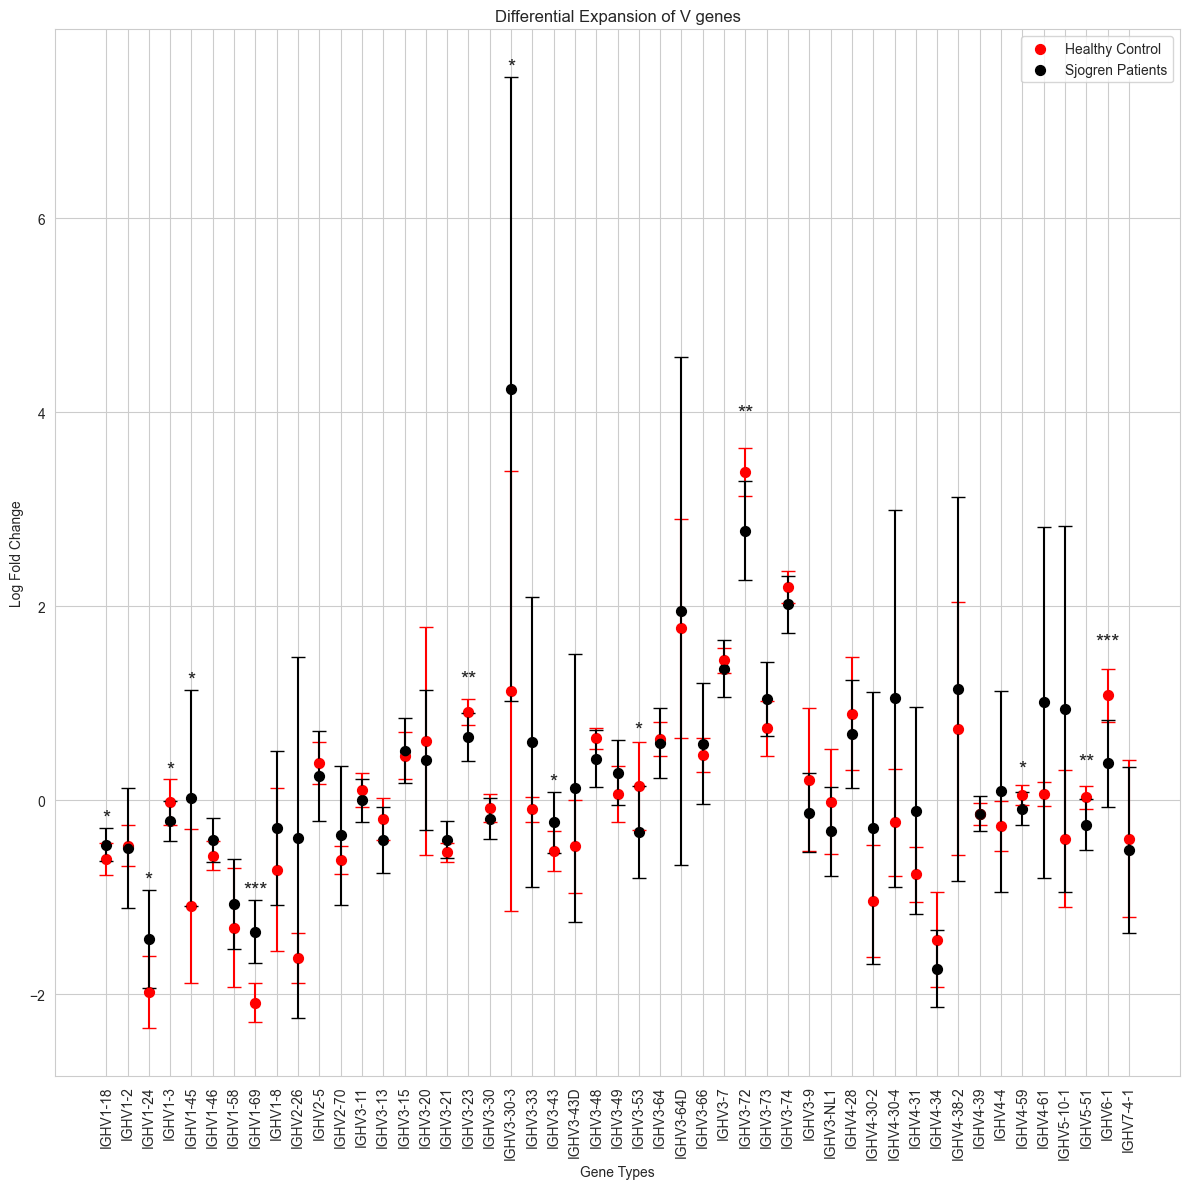

In [71]:
control_gene_types = list(filter_data(healthy_data).keys())
control_data_values = list(filter_data(healthy_data).values())

control_means = [np.mean(values) for values in control_data_values]
control_std = [np.std(values) for values in control_data_values]

exp_gene_types = list(filter_data(sjogren_data).keys())
exp_data_values = list(filter_data(sjogren_data).values())

exp_means = [np.mean(values) for values in exp_data_values]
exp_std = [np.std(values) for values in exp_data_values]

# Calculate p-values for each V gene using t-test
p_values = [stats.ttest_ind(control_data_values[i], exp_data_values[i]).pvalue for i in range(len(control_gene_types))]

# Create a dictionary to map p-values to significance levels
significance_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Initialize lists to store significance labels for each V gene
significance_labels = []

# Determine significance labels for each V gene
for p_value in p_values:
    for significance_level, label in significance_levels.items():
        if p_value <= significance_level:
            significance_labels.append(label)
            break
    else:
        significance_labels.append('')  # If no significance, add an empty label

plt.figure(figsize=(12, 12))
ax = plt.gca()

# Scatter plot and error bars for control and experimental groups
plt.scatter(range(len(control_gene_types)), control_means, label="Healthy Control", marker='o', color='red', s=50)
for i, mean_value in enumerate(control_means):
    plt.errorbar(i, mean_value, yerr=control_std[i], color='red', fmt='o', capsize=5)

plt.scatter(range(len(exp_gene_types)), exp_means, label="Sjogren Patients", marker='o', color='black', s=50)
for i, mean_value in enumerate(exp_means):
    plt.errorbar(i, mean_value, yerr=exp_std[i], color='black', fmt='o', capsize=5)

# Add significance labels over the bars
for i, label in enumerate(significance_labels):
    if label:
        plt.text(i, max(control_means[i], exp_means[i])+max(control_std[i], exp_std[i]), label, ha='center', va='bottom', fontsize=15)

plt.title("Differential Expansion of V genes")
plt.xlabel("Gene Types")
plt.ylabel("Log Fold Change")
plt.xticks(range(len(exp_gene_types)), exp_gene_types, rotation=90)
plt.legend()

plt.tight_layout()
plt.savefig('../Data/Figures/v_gene_expansion_with_p_values.png', dpi=500)
plt.show()


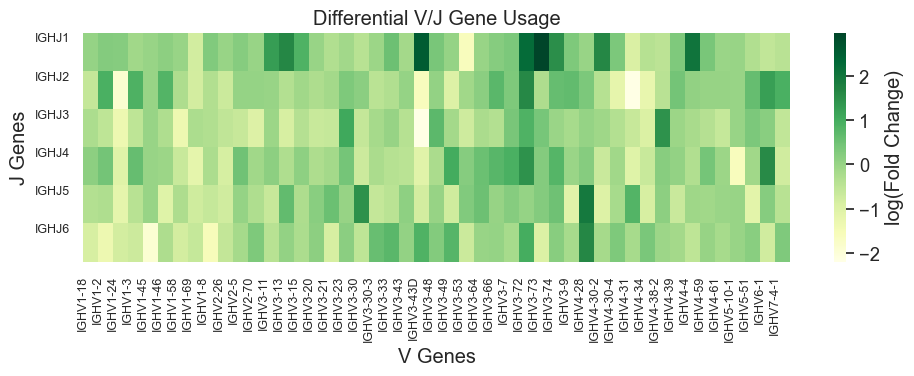

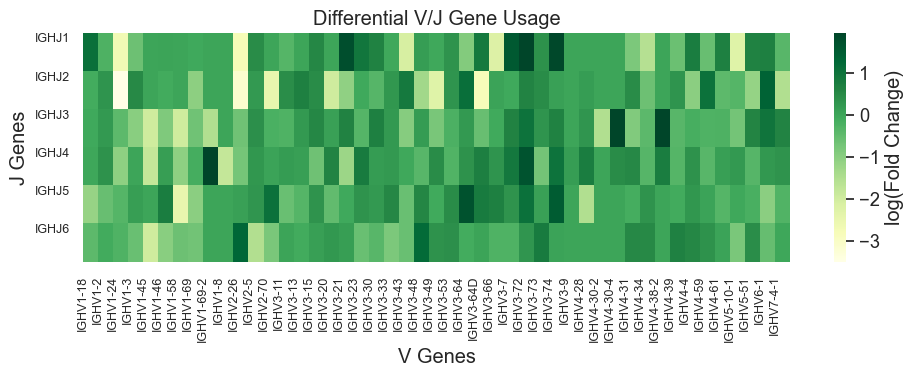

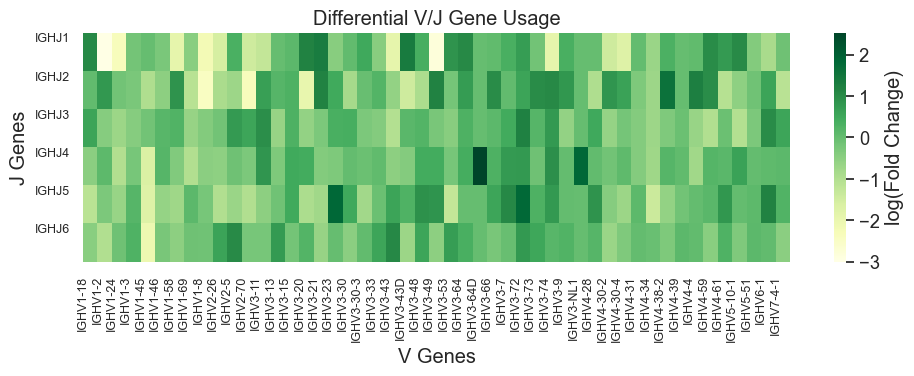

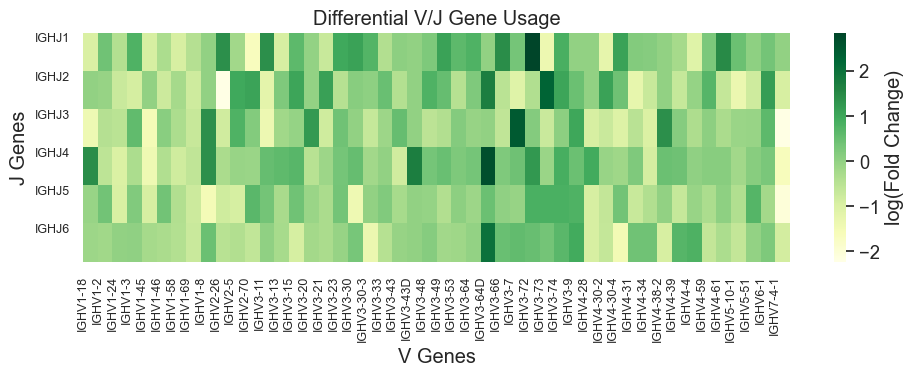

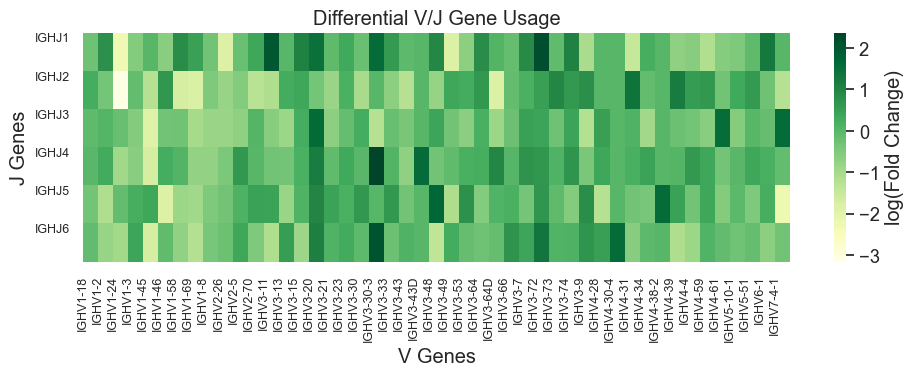

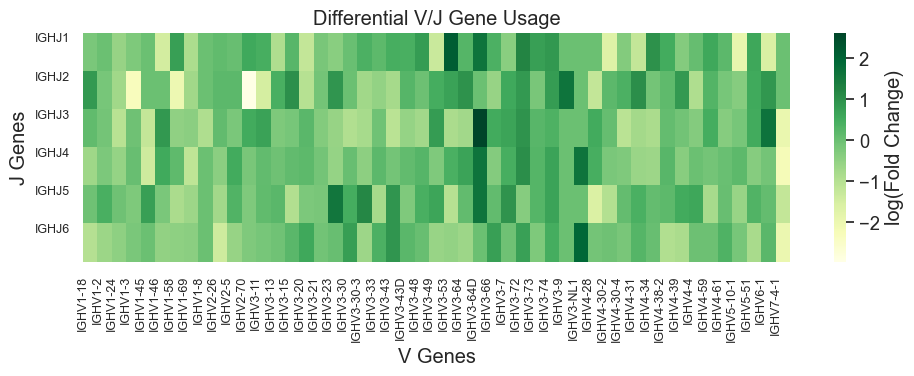

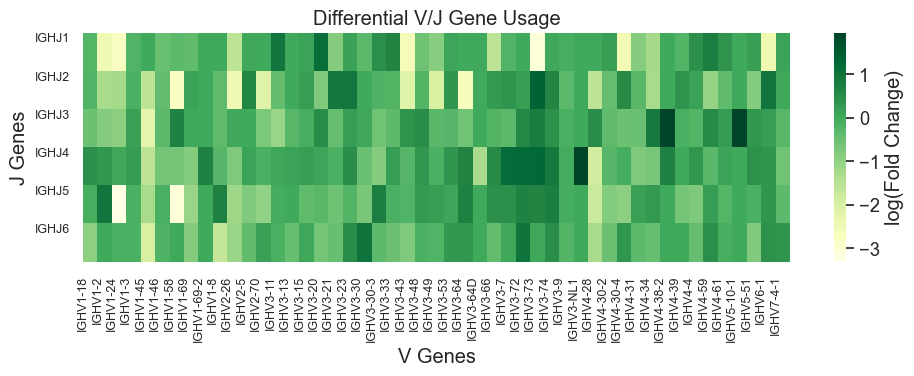

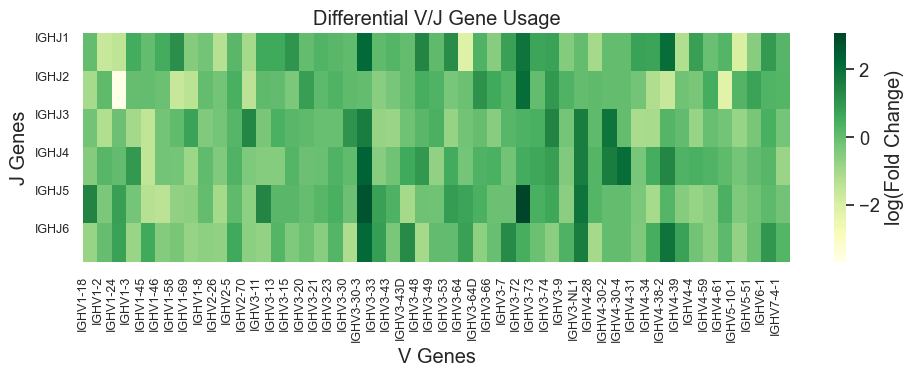

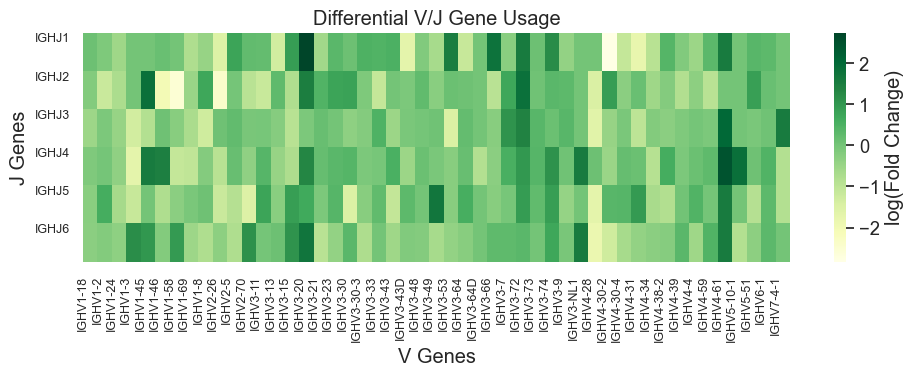

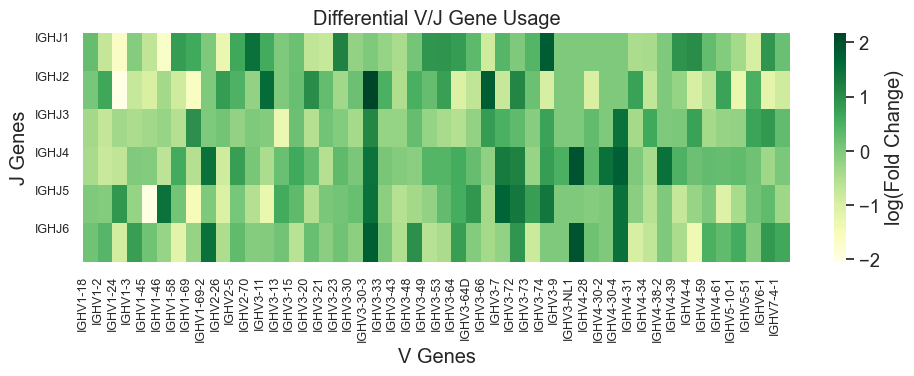

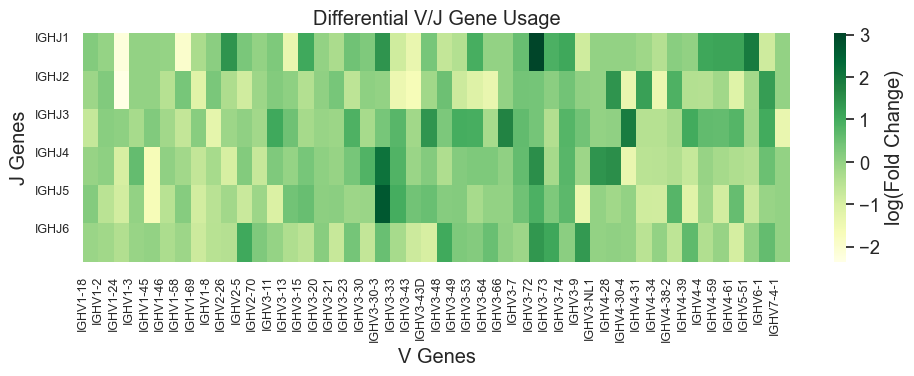

In [75]:
path =  '../Data/in_house_healthy/'
files = os.listdir(path)

for file in files:
    df = pd.read_csv(os.path.join(path, file), sep='\t')
    dataframe = preprocessing(df)
    index = dataframe()['v_call'].unique()

    df_naive = vj_gene_usage(dataframe.get_naive(), index)
    df_mature = vj_gene_usage(dataframe.get_mature(), index)

    df_naive.replace(0, 0.000001, inplace=True)
    df_naive = np.log10(df_naive)

    df_mature.replace(0, 0.000001, inplace=True)
    df_mature = np.log10(df_mature)

    df_change = df_mature - df_naive

    plt.figure(figsize=(10, 4))
    sns.set(font_scale = 1.2)
    sns.heatmap(df_change.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'log(Fold Change)'})

    plt.title('Differential V/J Gene Usage')
    plt.xlabel('V Genes')
    plt.ylabel('J Genes', rotation=90)

    ax = plt.gca()
    ax.set_xticks(range(len(df_change.index)))
    ax.set_xticklabels(df_change.index, fontsize = 9, ha='center')

    ax.set_yticks(range(len(df_change.columns)))
    ax.set_yticklabels(df_change.columns, rotation=0, va='top', fontsize = 9)

    plt.tight_layout()
    plt.savefig(f'../Data/diff_usage_healthy/{file.split(".")[0]}_differential_v_j_gene_usage.png', dpi=500)

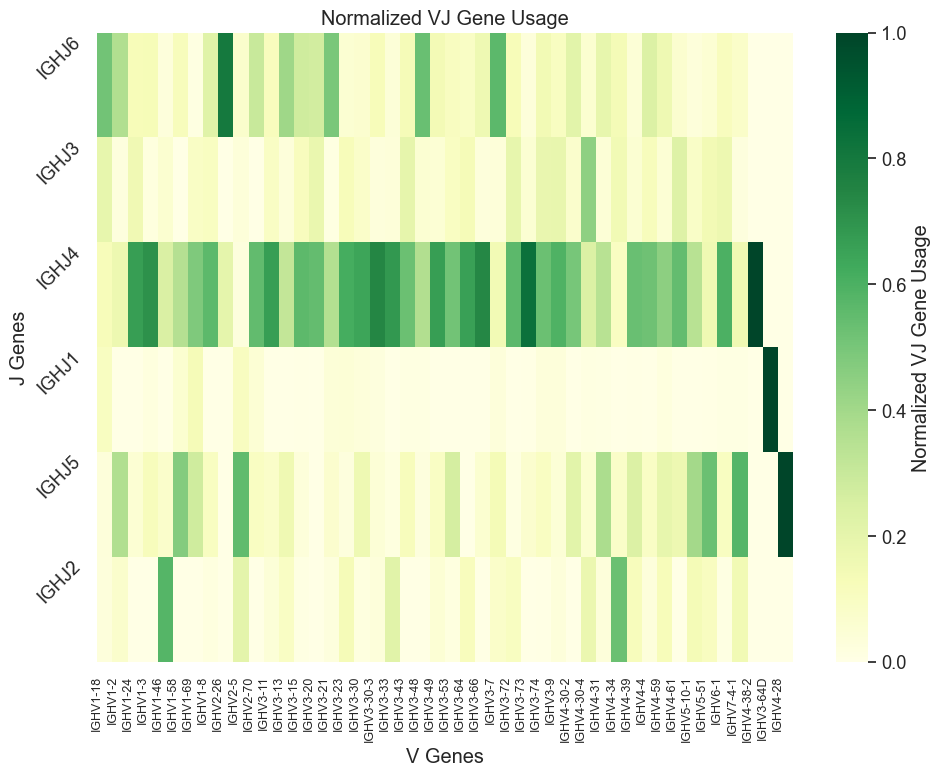

In [6]:
j_counts = dataframe.get_mature().groupby('v_call')['j_call'].apply(lambda x: (x.unique(), x.value_counts()))
v_genes = j_counts.index.to_list()
j_genes = j_counts.apply(lambda x: x[0]).to_list()
counts = j_counts.apply(lambda x: x[1].to_list()).to_list()

vj_gene_usage = {}
for i, v_gene in enumerate(v_genes):
    vj_gene_usage_dict = {isotype: count for isotype, count in zip(j_genes[i], counts[i])}
    vj_gene_usage[v_gene] = vj_gene_usage_dict

df = pd.DataFrame.from_dict(vj_gene_usage, orient='index').fillna(0)

df_normalized = df.div(df.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.2)
sns.heatmap(df_normalized.transpose(), annot=False, cmap='YlGn', cbar_kws={'label': 'Normalized VJ Gene Usage'})

plt.title('Normalized VJ Gene Usage')
plt.xlabel('V Genes')
plt.ylabel('J Genes', rotation=90)

ax = plt.gca()
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, fontsize = 9)

ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns, rotation=45, va='top')

plt.tight_layout()
plt.show()

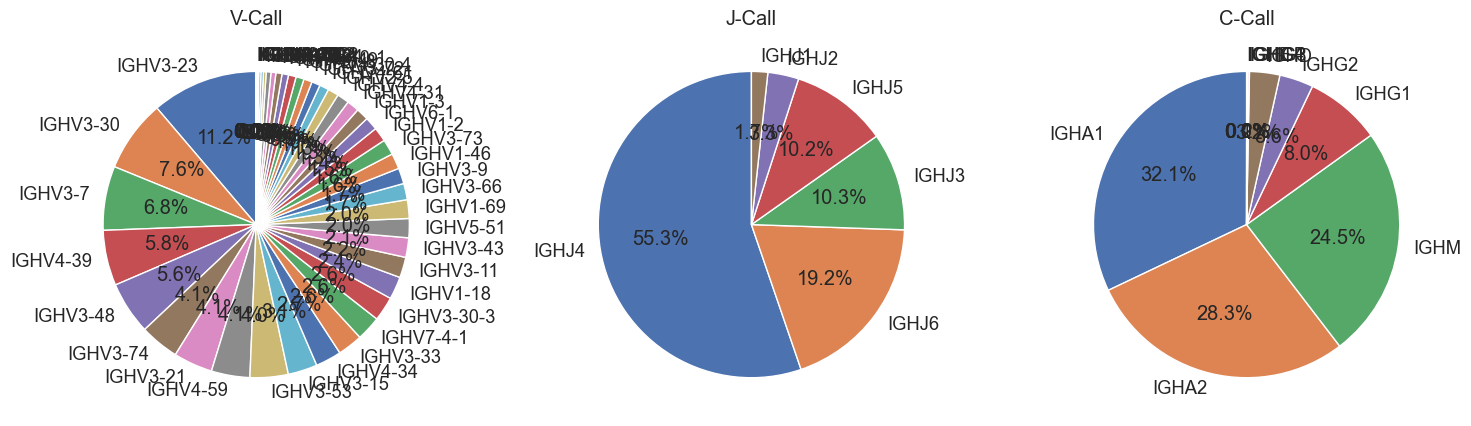

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(cluster_S8.dataframe['v_call'].value_counts(), labels=cluster_S8.dataframe['v_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('V-Call')
axes[1].pie(cluster_S8.dataframe['j_call'].value_counts(), labels=cluster_S8.dataframe['j_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('J-Call')
axes[2].pie(cluster_S8.dataframe['c_call'].value_counts(), labels=cluster_S8.dataframe['c_call'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('C-Call')

plt.tight_layout()
plt.savefig('../Data/Example/pie_chart.png', dpi=300)

count    9132.000000
mean      298.831143
std        11.910628
min       246.000000
25%       291.000000
50%       298.000000
75%       307.000000
max       357.000000
Name: sequence_alignment, dtype: float64

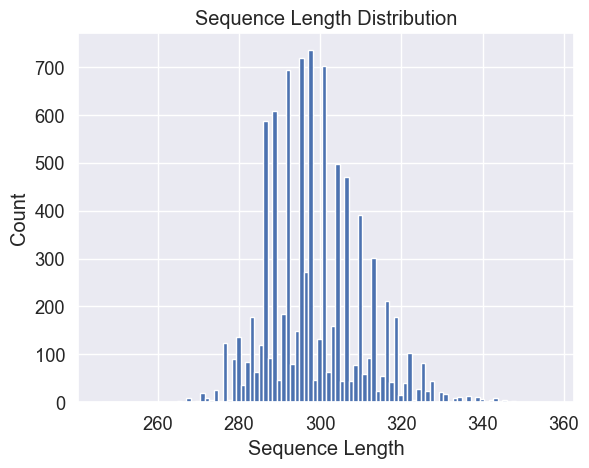

In [175]:
sequence_length = S8['sequence_alignment'].str.len()
sequence_length.hist(bins=100)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.savefig('../Data/Example/sequence_length.png', dpi=300)
sequence_length.describe()

count    9132.000000
mean       14.314936
std         3.702971
min         2.000000
25%        12.000000
50%        14.000000
75%        17.000000
max        29.000000
Name: cdr3_aa_len, dtype: float64

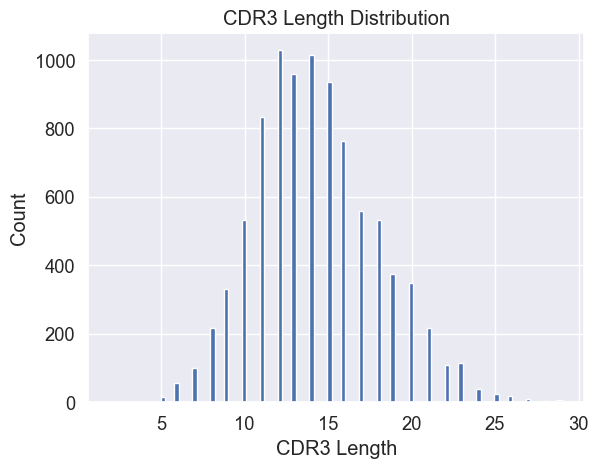

In [176]:
cdr3_length = cluster_S8.dataframe['cdr3_aa_len']
cdr3_length.hist(bins=100)
plt.title('CDR3 Length Distribution')
plt.xlabel('CDR3 Length')
plt.ylabel('Count')
plt.savefig('../Data/Example/cdr3_length.png', dpi=300)
cdr3_length.describe()

In [177]:
recombination_types = recombinations(S8)
CSRtypes = recombination_types()

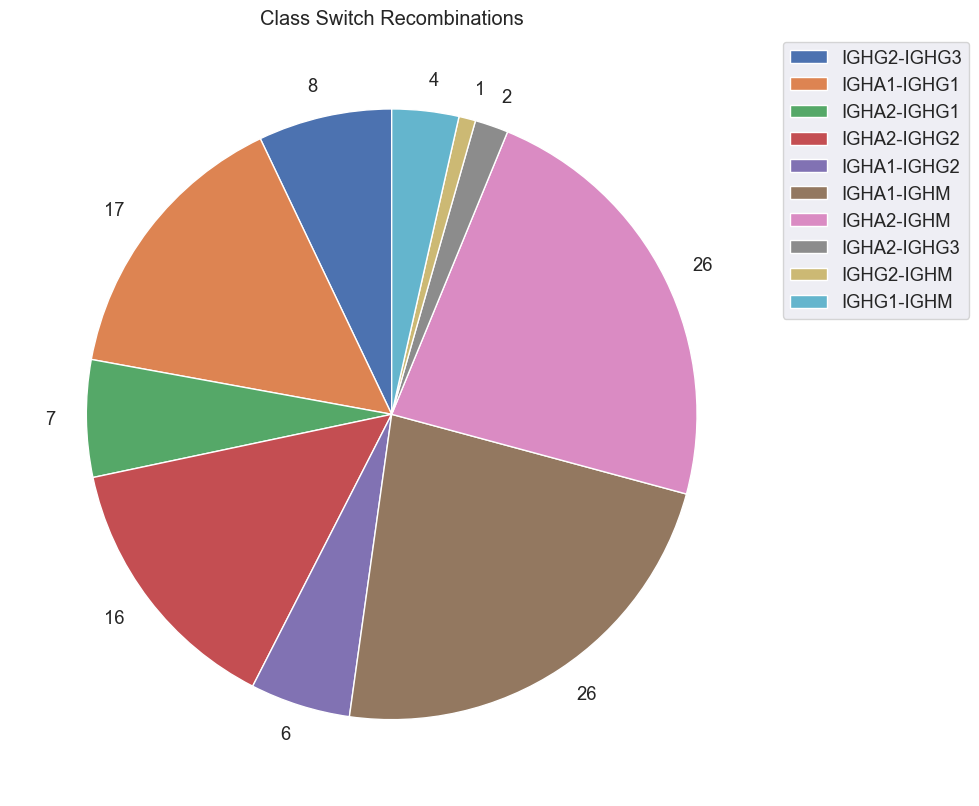

In [178]:
types = []
freq = []

for t, f in CSRtypes.items():
    types.append(t)
    freq.append(f)

plt.figure(figsize = (10,10))
plt.pie(freq, labels = freq, startangle=90)
plt.legend(labels = types, loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('Class Switch Recombinations')
plt.savefig('../Data/Example/CSR_types.png', dpi=300)